# Polynomial Regression

In [1]:
import numpy as np
import pandas as pd

In [22]:
# 예시 데이터 생성
m = 100 # sample number
X = 6 * np.random.rand(m, 1) - 3 # 0~6까지의 무작위수를 3만큼 빼줬으니까, -3 ~ 3 사이의 무작위수가 나온다.
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1) # 0.5X^2 + X + 2 에 std. normal distribution의  noise를 더했음

# 예시 데이터의 plotting.
import matplotlib.pyplot as plt
plt.scatter(X, y, s=10)
plt.show()

In [8]:
## 참고.
np.random.rand(2, 1) # uniform distribution
np.random.randn(2, 1) # std. normal distribution
### 각 확률분포에서 random하게 shape 크기의 ndarr를 반환함.
##

array([[-0.73640378],
       [ 0.25275838]])

In [31]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) 
# include_bias option이 있는 이유 : 
# sklearn의 LinearRegression은 기본값으로 fit_intercept가 True이므로, PolyFeat에서 bias를 만들 필요가 없다.
# statistics의 OLS는 기본값으로 bias 학습이 되지 않기 때문에, PolyFeat에서 bias를 만들어서 넣어주면 된다.
# 각 라이브러리마다 기본값이 차이가 있기 때문에 이게 옵션으로 들어가게 되는 듯
X_poly = poly_features.fit_transform(X)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

lin_reg = LinearRegression()
sgd_reg = SGDRegressor()

lin_reg.fit(X_poly, y)
sgd_reg.fit(X_poly, y)

c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

In [33]:
lin_reg.intercept_, lin_reg.coef_

(array([1.90622438]), array([[1.03163992, 0.52308473]]))

In [34]:
sgd_reg.intercept_, sgd_reg.coef_

(array([1.81156785]), array([1.03505974, 0.55291784]))

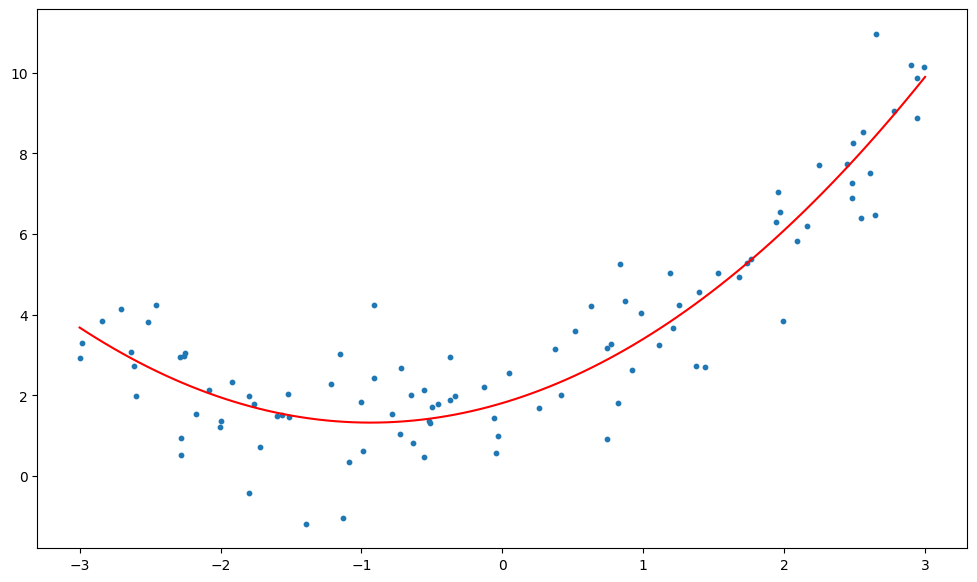

In [39]:
import numpy as np
X_predict = np.linspace(-3, 3, 100).reshape(-1, 1)
X_pred_poly = poly_features.transform(X_predict)
# y_predict = lin_reg.predict(X_pred_only)
y_predict = sgd_reg.predict(X_pred_poly)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.plot(X_predict, y_predict, c='r')
plt.scatter(X, y, s=10)
plt.show()

## 과대적합 or 과소적합?
1. 교차 검증을 통해 확인하는 방법
- 훈련 세트에서 성능이 좋은데 검증 세트에서 성능이 나쁘다면 과대적합
- 훈련 세트, 검증 세트 모두 성능이 좋지 않다면 과소적합
- 이에 따라 적절한 차수를 찾아서 Poly의 degree로 사용하면 좋음

2. 학습 곡선을 통해 확인하는 방법

In [66]:
from sklearn.metrics import mean_squared_error # loss function이자, 성능 평가 방법의 하나.
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=77) # 80 : 20 개수비율로 나눔.
    train_errors, val_errors = [], []
    for m in range(5, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")
    plt.ylim(0, 5)
    return train_errors, val_errors

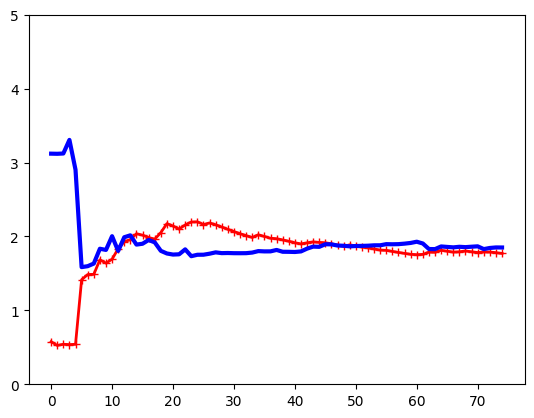

In [67]:
# 단순 선형회귀의 학습곡선
lin_reg = LinearRegression()
te, ve = plot_learning_curves(lin_reg, X, y)

빨간색과 파란색이 겹쳐져 있지만, RMSE의 크기는 좀 크다(2). y의 평균에 +- 2가 되어있단 뜻인데,

In [70]:
print(np.mean(y), np.std(y))

3.5236209166336 2.6200333446952486


y의 평균은 3.52에, std dev가 2.62인데 RMSE가 2라면 꽤 차이가 크지않나.
#### (참고) RMSE의 좋고 나쁨은 어떻게 평가할까?

일반적으로 RMSE의 좋고 나쁨은 target y의 scale에 따라 다르다. 그러니까, 내가 한 것처럼 평균과 stddev를 계산해서 대강 파악할 수밖에 없음

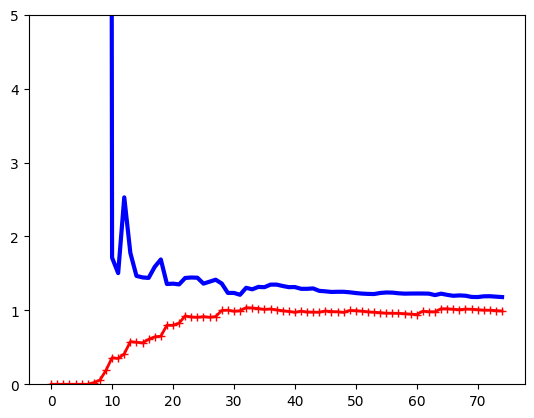

In [68]:
# 10차 다항 회귀 모델의 학습 곡선
# Pipeline을 사용해보자.
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

te, ve = plot_learning_curves(polynomial_regression, X, y)

빨간색(훈련)과 파란색(검증) 곡선 사이에 공간이 있다 --> 훈련 데이터셋보다 검증데이터셋이 성능이 안좋게 나온다. 과적합되어 있다고 볼 수 있음

## 과소적합/과대적합을 해결하는 방법

1. 과소적합

- 더 복잡한 모델을 사용하거나, 더 나은 특성을 추가하기

2. 과대적합

- 검증 오차가 훈련 오차에 근접할 때까지 더 많은 훈련 데이터를 추가
- Regularization, 또는 단순한 모델 사용

## 편향/분산 트레이드오프

모델의 일반화 오차 = 편향 + 분산 + (줄일 수 없는 오차)

이 오차는, test set의 X와 y간 오차를 말하는 게 아니다. 모델이 가진 일반화 오차의 성격에 두 가지가 있다는 것.

1. 편향
- 잘못된 가정으로 인한 것.
- 편향이 큰 모델은 과소적합되기 쉽다.(단순 선형 회귀)

2. 분산
- 훈련 데이터의 변동에 모델이 민감하게 반응하는 것
- 분산이 큰 모델은 과대적합되기 쉽다.(고차 다항 회귀)

# 규제가 있는 선형 모델
릿지 회귀, 라쏘 회귀, 엘라스틱넷 회귀

** 규제가 있는 선형 모델의 경우, 특성 간 scale을 맞춰주는 것이 매우 중요하다.
그래야 원점이 중심인 모델이 되고, 그게 규제의 의도를 더 확실하게 반영하게 된다. 

(원점이 중심이 아닌 모델은 조금만 바꿔도 가중치 변화가 엄청 커진다)

## l1, l2 norm
- l1 : 절댓값 합
- l2 : 제곱 합

In [71]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
ridge_reg = Ridge(alpha=1, solver='cholesky') # l2 norm 사용
lasso_reg = Lasso(alpha=0.1) # l1 norm 사용
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) # lasso 비중이 0.5다.

## 조기 종료

In [80]:
from copy import deepcopy # 모델의 카피를 위해 사용함.

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

poly_scalar = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scalar.fit_transform(X_train)
X_val_poly_scaled = poly_scalar.transform(X_val)

# warm_start=True : for문이나 while문 같은 곳에서 학습을 반복해야 할 때 사용함, 이전의 학습 파라미터를 간직한 채로 학습을 재개하는 옵션.
sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    if epoch%100==0:
        print(epoch)
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)

    # 최소가 나온 모델을 계속해서 저장해둠.
    # 모델을 copy하려면 deepcopy를 사용하는구나.
    if val_error < minimum_val_error:
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

0
100
200
300
400


c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

500
600
700
800
900


c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\TIL\ML\venv_ml\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

In [81]:
best_epoch

999

In [82]:
best_model

SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             tol=None, warm_start=True)

## 로지스틱 회귀

선형회귀에서 사용하는 선형 가중합(+편향) 을 그대로 로지스틱 회귀에 넣어서 값을 도출함.
#### (참고) 선형회귀와 로지스틱 회귀의 비교

1. 선형회귀
- 모델식 : y^ = a * X + b
- loss function : MSE
- target의 datatype : float, int 등.

2. 로지스틱 회귀
- y^ = sigmoid(a * X + b)
- loss function : cross entropy
- target의 datatype : object. 분류를 위한 범주형 데이터가 됨

In [83]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [88]:
X = iris['data'][:, 3:] # 꽃잎의 너비
y = (iris['target']==2).astype(np.int8)

In [90]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

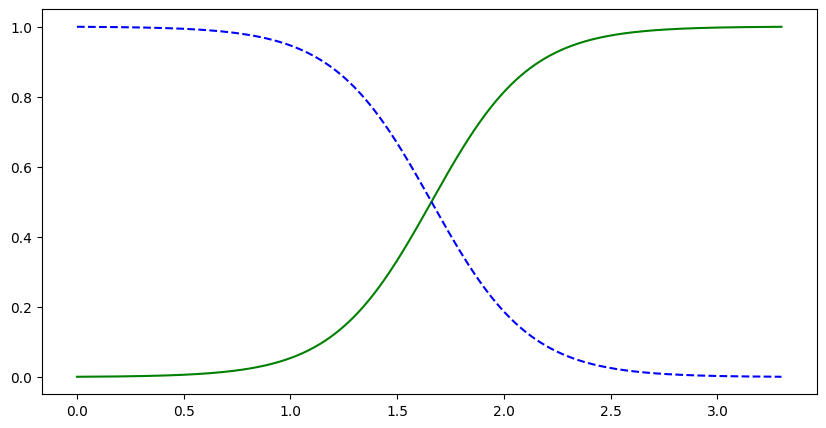

In [98]:
X_new = np.linspace(0, 3.3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.figure(figsize=(10, 5))
plt.plot(X_new, y_proba[:, 1], "g-") # target = 1일 확률
plt.plot(X_new, y_proba[:, 0], "b--") # target = 0일 확률
plt.show()

In [113]:
for i, (x, prob) in enumerate(zip(X_new, y_proba)):
    if abs(np.diff(prob)) < 0.01:
        print(i, np.diff(prob), x)

502 [-0.00466746] [1.65825826]
503 [0.00248925] [1.66156156]
504 [0.0096457] [1.66486486]


In [107]:
len(y_proba)

1000

로지스틱 회귀도 l1, l2 페널티로 규제할 수 있으며, l2페널티가 기본임. 파라미터는 C로, C=높을수록 규제 줄어듬

## 소프트맥스 회귀
로지스틱 회귀의 파라미터에,
- multi_class = "multinomial",
- solver = "lbfgs"
를 추가해서 모델 생성할 수 있음.

multi_class에 아무것도 넣지 않으면 기본값으로 OvA 전략을 통해 여러 class를 분류한다.
* OvA : e.g. 1, 2, 3의 class가 있을 때,
- (1 ~ 1아님) 의 모델 하나
- (2 ~ 2아님) 의 모델 하나
- (3 ~ 3아님) 의 모델 하나
3개의 모델을 생성해서 가장 높은 probability를 가지는 class를 결과값으로 내놓는 방법.

In [114]:
X = iris["data"][:, (2, 3)] # 꽃잎의 길이와 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10) # lbfgs가 solver이고, 규제(C) 10.
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [115]:
softmax_reg.predict([[5, 2]])

array([2])

In [120]:
softmax_reg.predict_proba([[5, 2]]) # 3개의 확률을 내놓는다!

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# 4장 끝.